## gml-extent-maker

* Dataset
     * R6.x806.000:0022 - X-band Radar measurements collected during the Submesoscale Processes and Lagrangian Analysis on the Shelf (SPLASH) experiment aboard R/V Walton Smith cruise WS17107 from
* Source data
     * kml files of Near Surface Current, KMZ files of Bathymetry extents
     * making extents from surface currents


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob, os
import pprint
import pandas as pd
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt

from osgeo import osr
from osgeo import ogr
from tqdm import tqdm
from geopandas import GeoDataFrame, GeoSeries
from shapely import geometry
from shapely.geometry import box, mapping, Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon, shape
from geomEngine import *
from gmlEngine import get_rounded_geom, gmlReplacer, gmlMaker
from concave_hull import alpha_shape_vector

import inspect
output_notebook()

Loading BokehJS ...

In [2]:
pointList = []
for file in tqdm(glob.glob("./data_full/*.shp")):
    gdf = gpd.read_file(file)
    multiLine = gpd.tools.collect(gdf['geometry']) # collect all linestrings into single multiline
    multiLine = remove_z(multiLine)
    pointList.extend(convert2ptsList(multiLine))

print('# of points ', len(pointList))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.00s/it]

# of points  608025


In [3]:
multiPt = MultiPoint(pointList)
#plot_geoms(multiPt)

(1129, 'coords', 2, 'geoms', 'MultiPolygon')


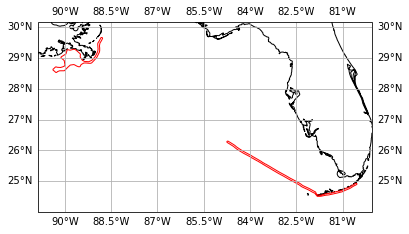

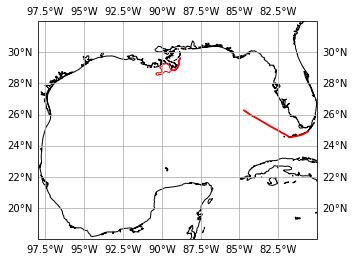

Wall time: 54.5 s


In [4]:
%%time
# Concave Hull

alpha = 10
concave_hull, edge_points = alpha_shape_vector(pointList, alpha=alpha)
print(len_geom(concave_hull))
plot_geoms(concave_hull)

In [5]:
## Simplfy concave hull to get > 500 coordinates

temp_gs = GeoSeries(concave_hull)
temp_gs = temp_gs.set_crs("EPSG:4326")
simp_temp_gs = temp_gs.to_crs(epsg=7593).simplify(500)
simp_concave_hull = (simp_temp_gs.to_crs(epsg=4326))[0]
print(type(simp_concave_hull))
print(len_geom(simp_concave_hull))

<class 'shapely.geometry.multipolygon.MultiPolygon'>
(209, 'coords', 2, 'geoms', 'MultiPolygon')


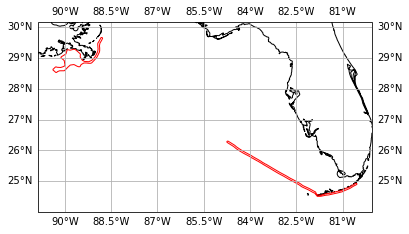

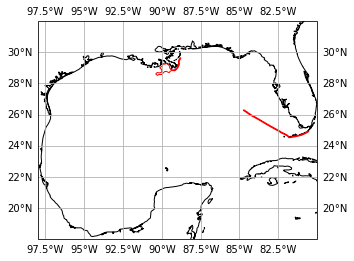

Wall time: 302 ms


In [6]:
%%time

#geom_comparison_bokeh_plot(multiPt,simp_concave_hull)
plot_geoms(simp_concave_hull)

In [7]:
newgml = gmlMaker(get_rounded_geom(simp_concave_hull))
gmlReplacer(newgml,"extent-metadata.xml")